Number of labels: 1000


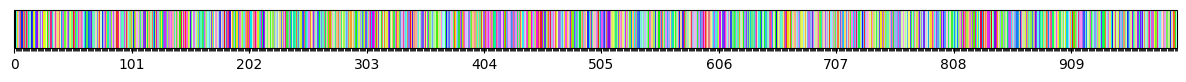

In [64]:
import napari
from PIL import Image
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import pandas as pd
from skimage.draw import line
from skimage.measure import label, regionprops_table
from skimage.transform import rotate
import tifffile
clist = napari.utils.colormaps.label_colormap(20)
from rand_cmap import rand_cmap
label_cmap = rand_cmap(1000, type='bright', first_color_black=True, last_color_black=False, verbose=True)

def crop_region(single_cell):
    true_y, true_x = np.where(single_cell)
    
    # Determine the bounding box coordinates
    min_x, max_x = true_x.min(), true_x.max()
    min_y, max_y = true_y.min(), true_y.max()
    
    # Crop the array to the bounding box around the mask
    cropped_single_cell = single_cell[min_y:max_y+1, min_x:max_x+1]
    return cropped_single_cell

from skimage.measure import regionprops_table
from skimage.transform import rotate

In [65]:
lines = pd.read_csv("to_segment/lines.csv")

In [66]:
masks_stack_omni = tifffile.imread("segmented/bact_fluor_omni.tif")
masks_stack_symbac = tifffile.imread("segmented/symbac_seg.tif")

In [85]:
def get_patch_widths(masks_stack, lines, plot = False, return_stacks = False):
    marked_indexes = lines["axis-0"].unique()

    avg_cell_widths = []
    cell_stack_size = []
    stack_mask_IDs = []
    for i in marked_indexes:
        masks = masks_stack[int(i)]
        mask_lines = lines.query("`axis-0` == @i")
        line_indexes = mask_lines["index"].unique()
        if plot:
            plt.figure(figsize=(20,20))
            plt.title(i)
            plt.imshow(masks, cmap = label_cmap, interpolation='none')
            plt.axis("off")
        for line_index in line_indexes:
            single_line = lines.query("index == @line_index")
            assert len(single_line) == 2
            
            (y1, x1), (y2, x2) = (single_line.query("`vertex-index` == 0")[["axis-1", "axis-2"]]).iloc[0].tolist(), (single_line.query("`vertex-index` == 1")[["axis-1", "axis-2"]]).iloc[0].tolist()
            if plot:
                plt.plot([x1,x2],[y1,y2], c = "r")
                plt.savefig(f"patch_mask_plots/{i}.svg")
            if math.isnan(y1):
                pass
            else:
                rr, cc = line(int(y1),int(x1),int(y2),int(x2))
                mask_IDs, mask_counts = np.unique(masks[rr,cc], return_counts=True)
                cleaned_mask_IDs = []
                for mask_ID in mask_IDs:
                    if mask_ID > 0:
                        cleaned_mask_IDs.append(mask_ID)
                stack_mask_IDs.append([i, cleaned_mask_IDs])


    all_widths = []
    all_stacks = []
    for stack_ID, mask_IDs in stack_mask_IDs:
        masks = masks_stack[int(stack_ID)]
        stack = np.zeros_like(masks)
        for i, mask_ID in enumerate(mask_IDs):
            stack = stack + (masks == mask_ID) * (i+1)
        
        stack = crop_region(stack)
        regionprops = regionprops_table(stack, properties=["orientation"])
        orientations = np.rad2deg(regionprops["orientation"])
        if orientations.std() < 10:
            stack_orientation = (orientations).mean()
            rotated_stack = rotate(stack, angle = -stack_orientation, resize=True, preserve_range=True, order = 0)
            all_stacks.append(rotated_stack)
            if plot:
                plt.imshow(rotated_stack, cmap = label_cmap)
                plt.show()
    
            width = []
            for i in range(rotated_stack.shape[0]):
                width.append(
                    np.sum((rotated_stack > 0)[i])
                )
            all_widths.append(np.max(width)/len(mask_IDs))
            #print(len(mask_IDs))
    if return_stacks:
        return all_stacks
    return all_widths

In [91]:
np.mean(get_patch_widths(masks_stack_omni, lines)) * 0.11

0.9575238095238097

In [100]:
np.mean(get_patch_widths(masks_stack_symbac, lines)) * 0.11 

0.9313333333333333

In [94]:
np.std(get_patch_widths(masks_stack_symbac, lines)) * 0.11

0.0276480143665454

In [96]:
est_std = np.std(get_patch_widths(masks_stack_omni, lines)) * 0.11  * np.sqrt(np.mean([5,5,6,5,5,6,6]))
est_std

0.06810444731029118

In [89]:
est_std / (np.mean(get_patch_widths(masks_stack_symbac, lines)) * 0.11)

0.06916742020086944

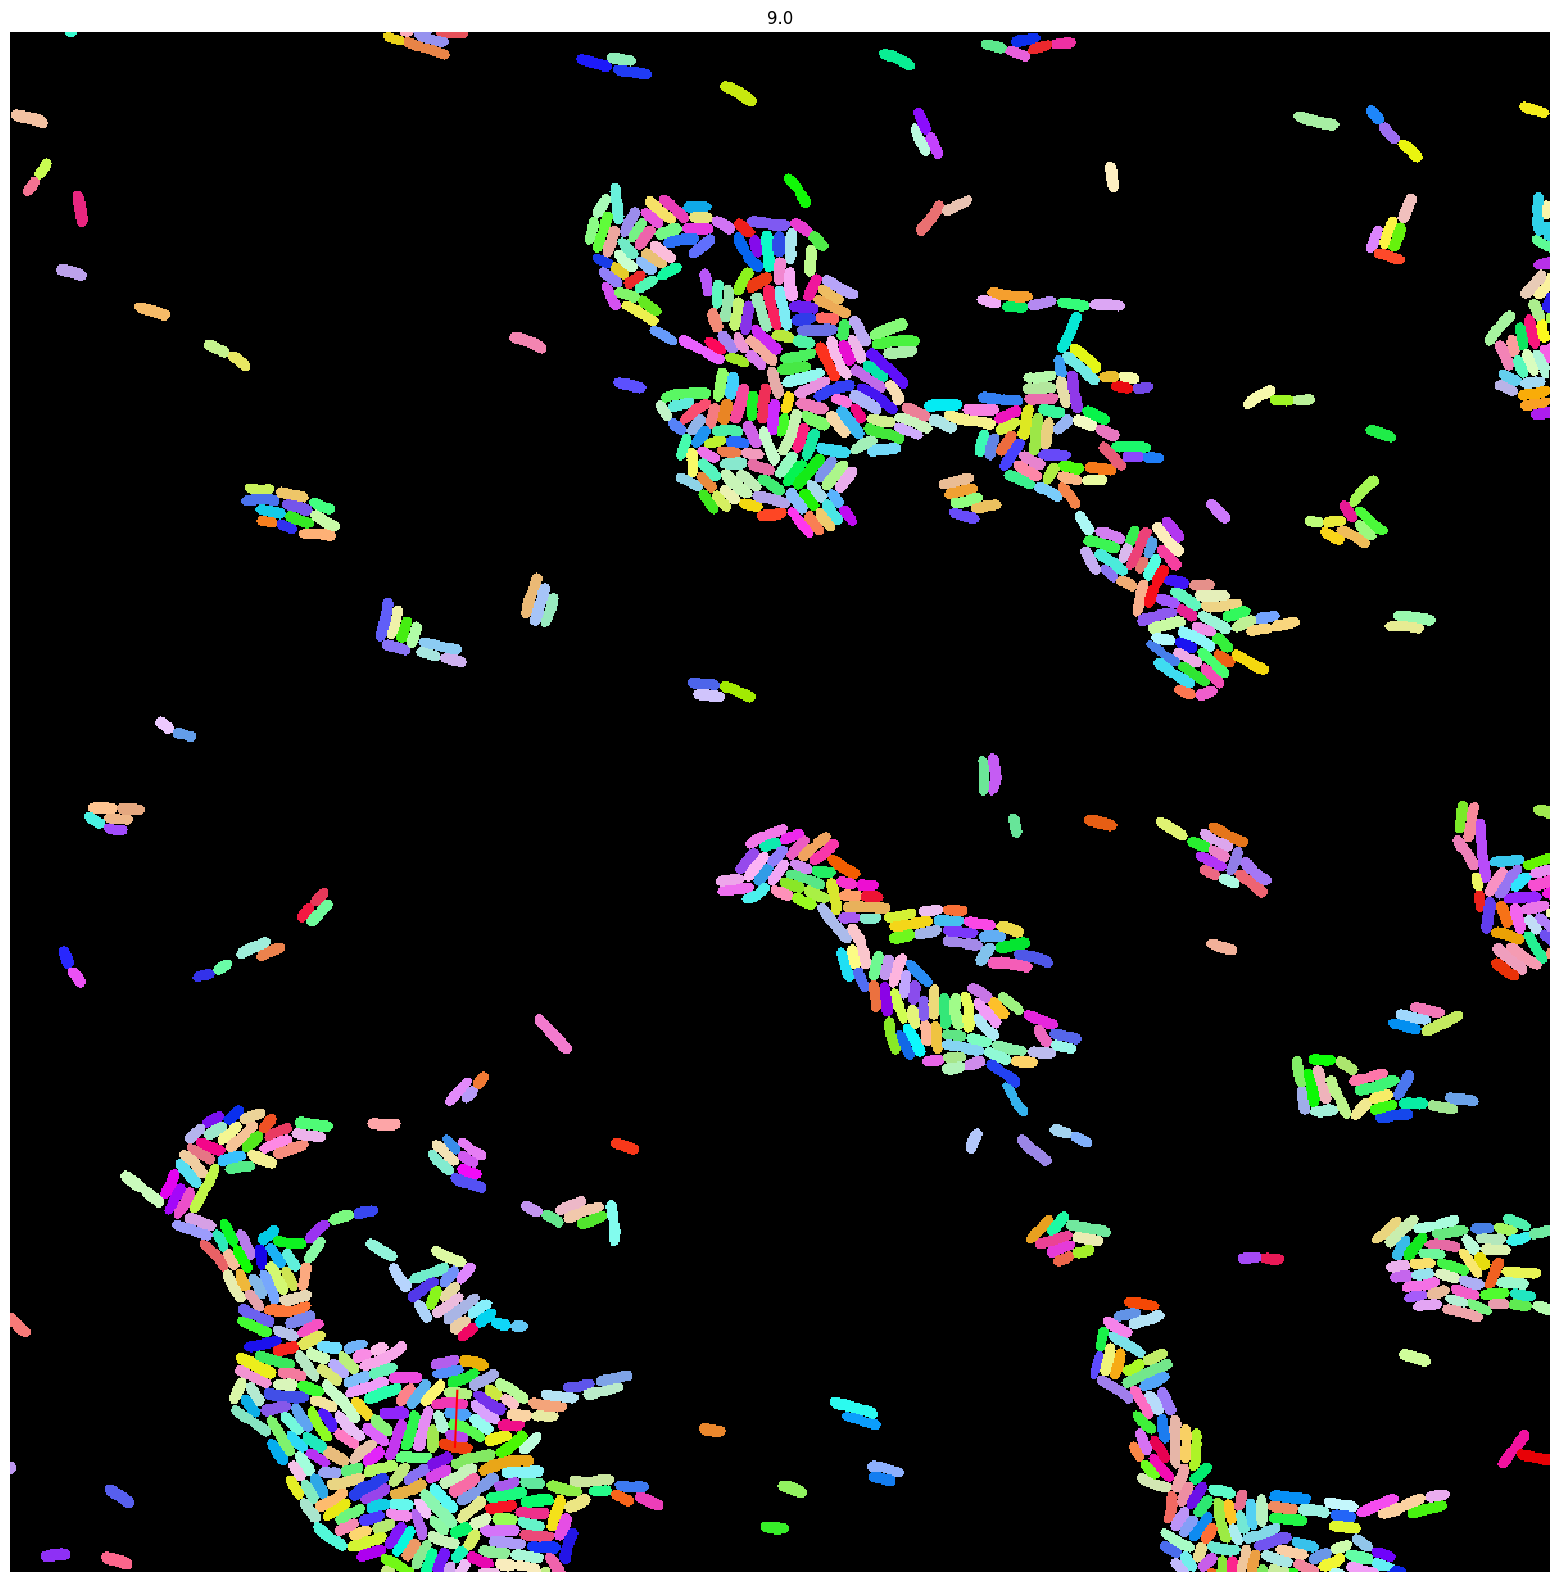

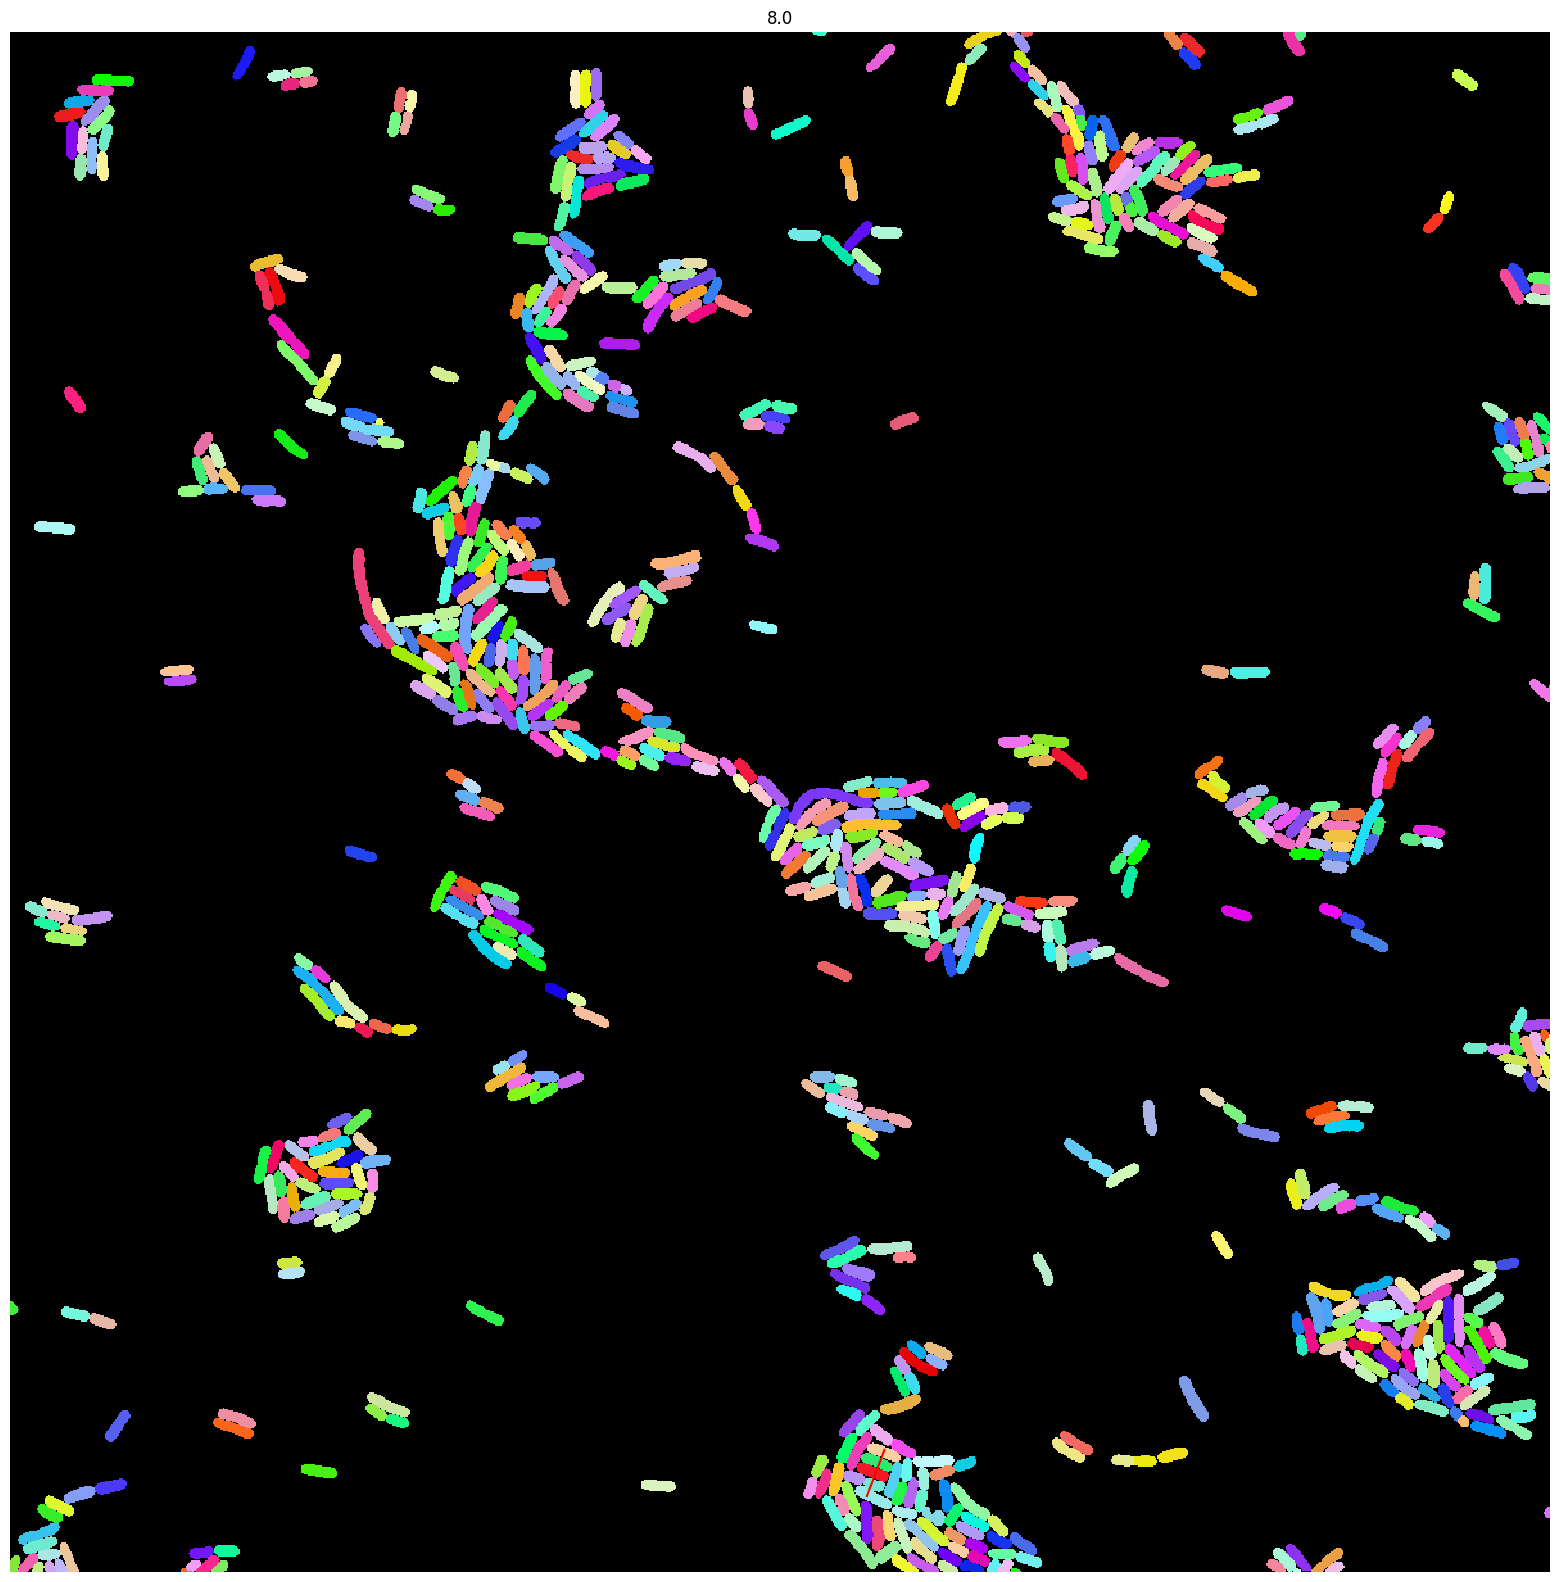

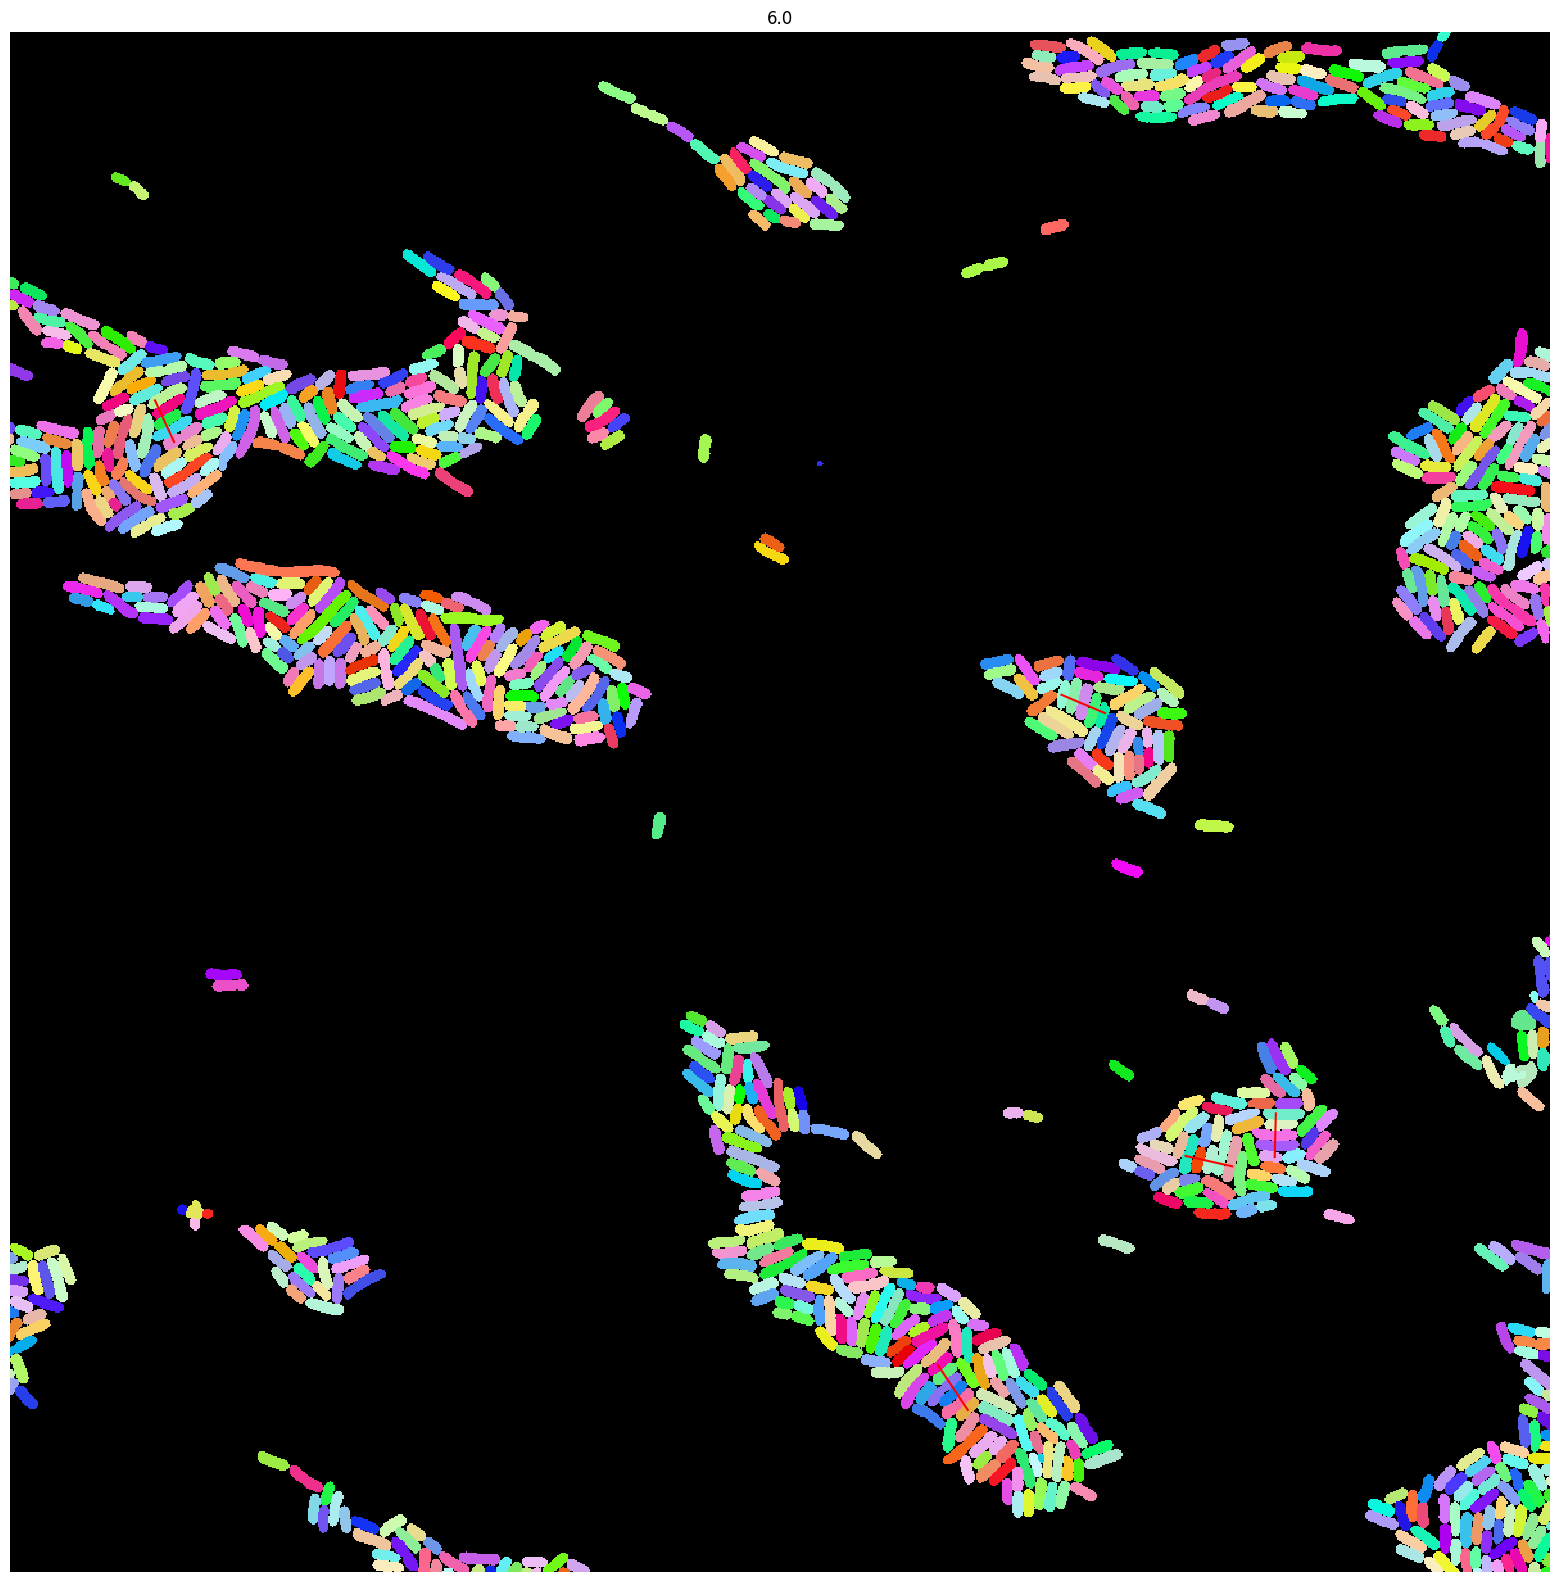

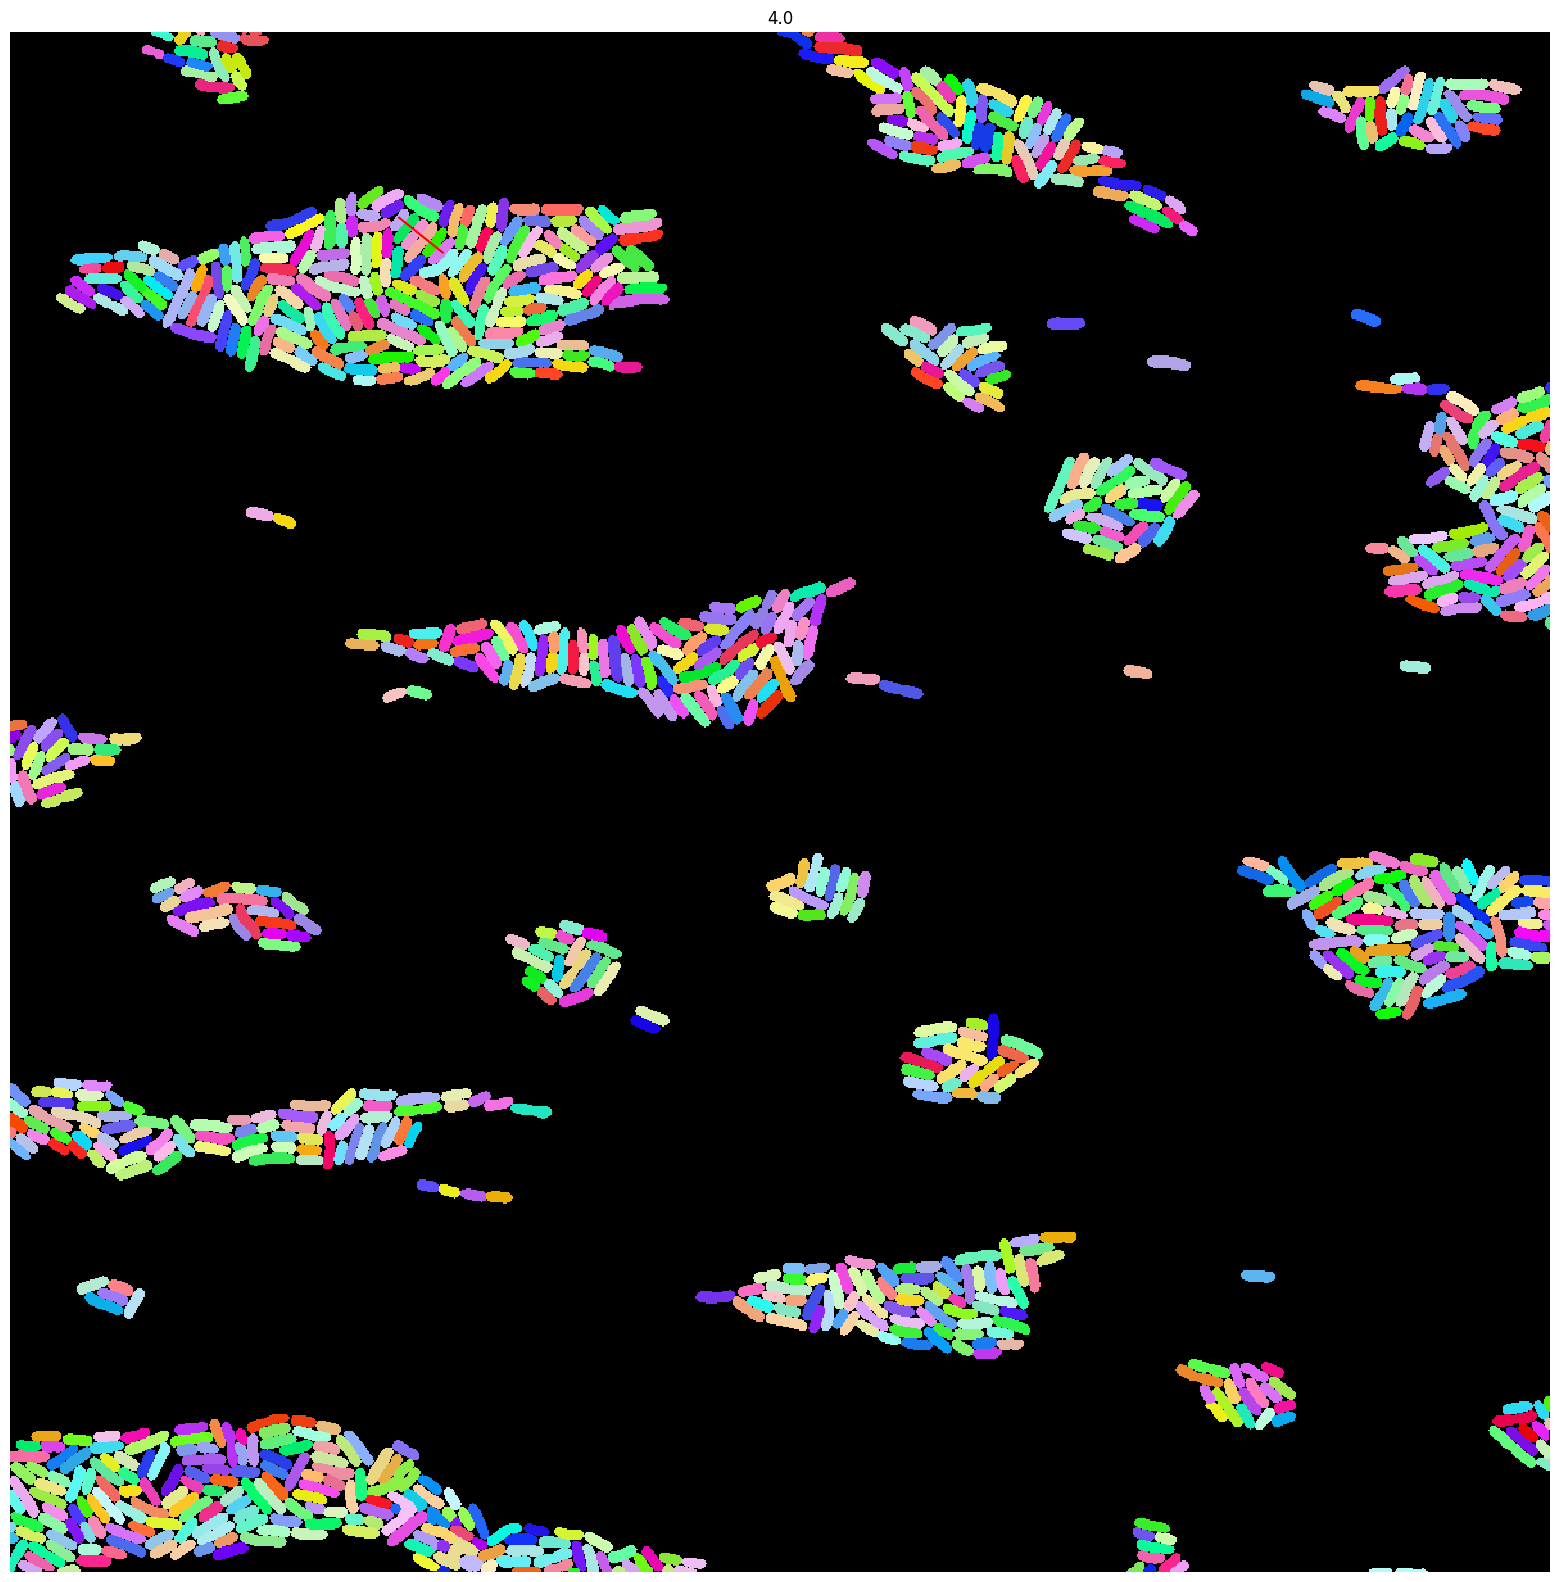

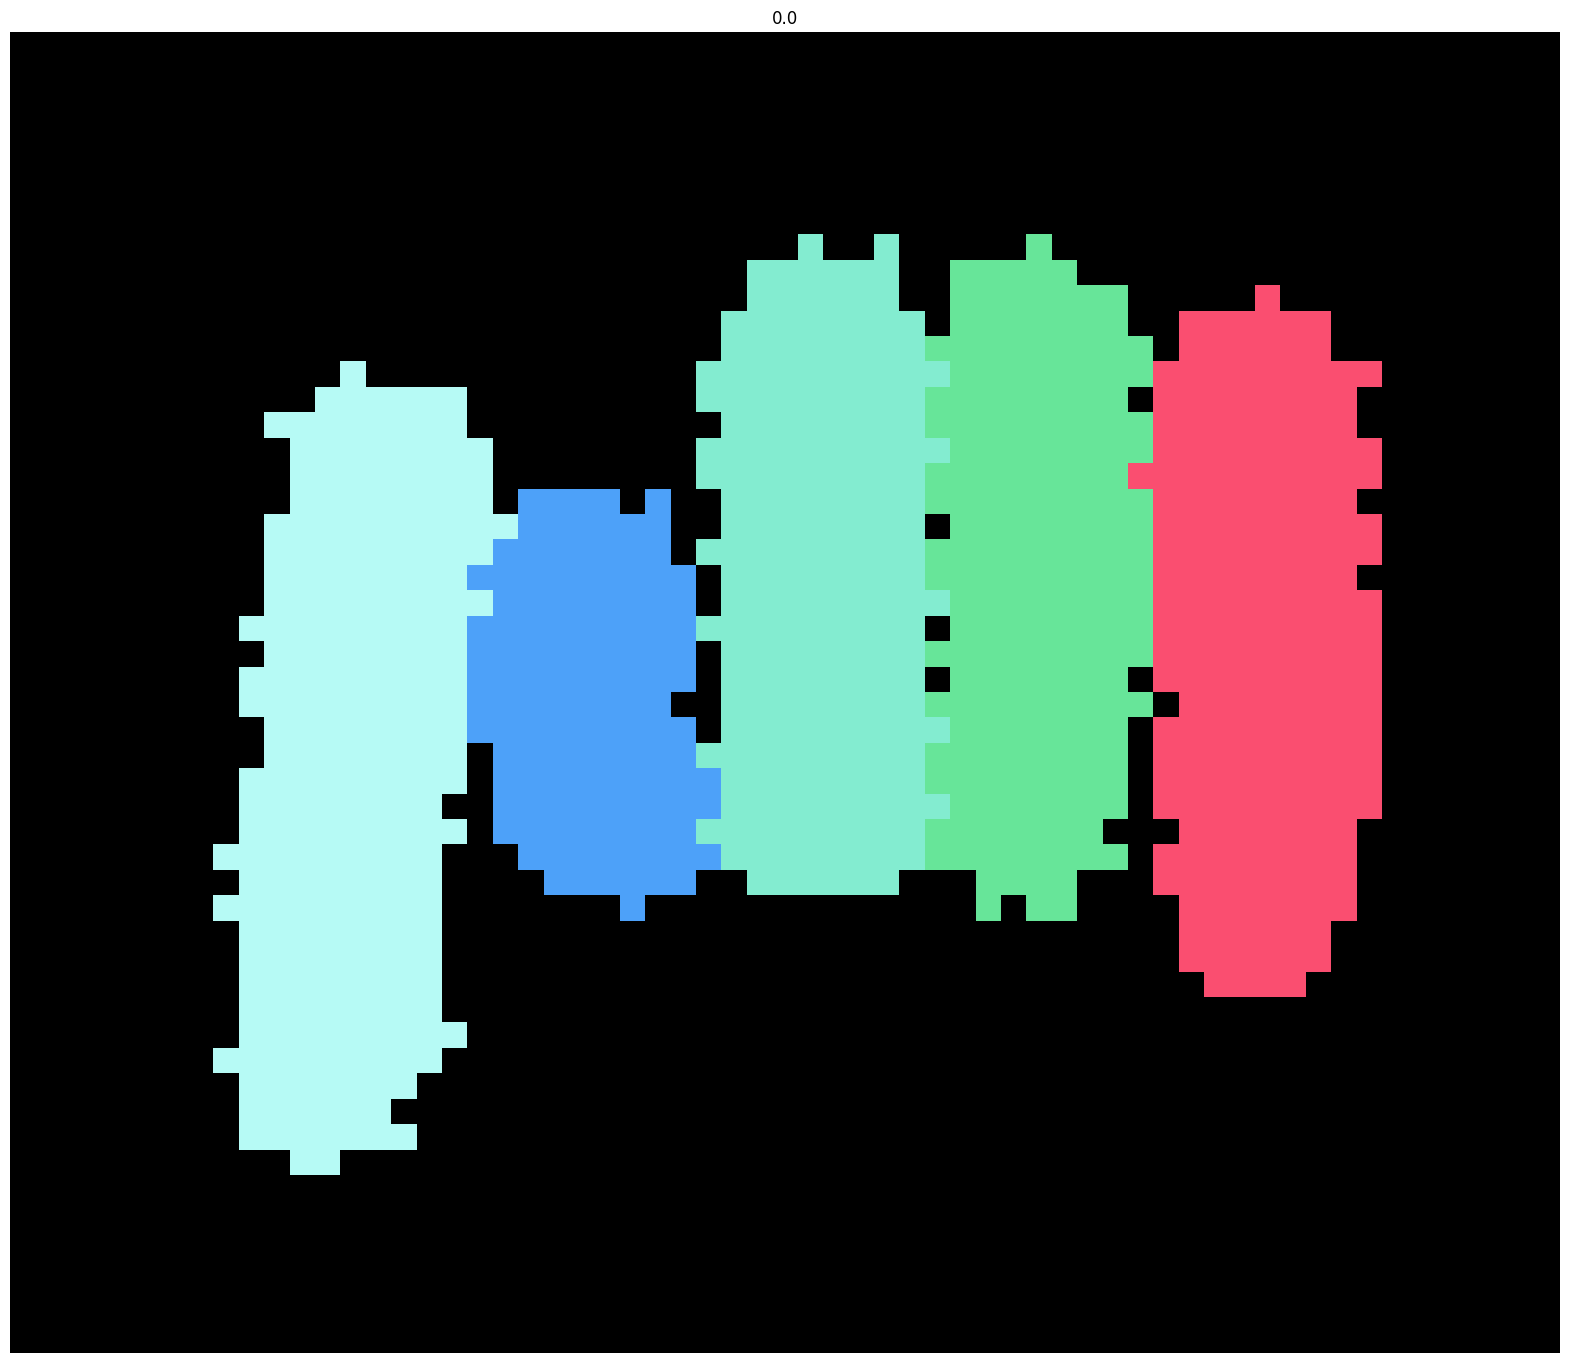

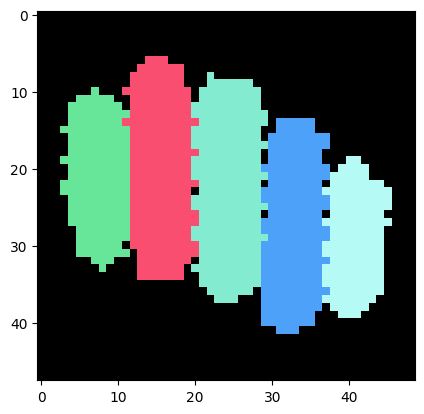

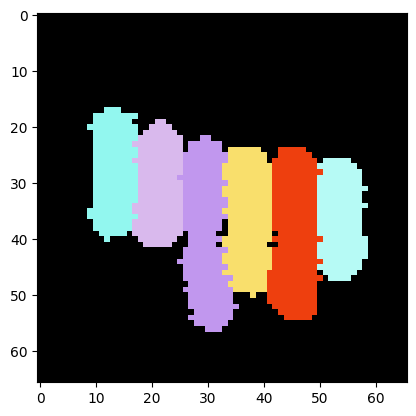

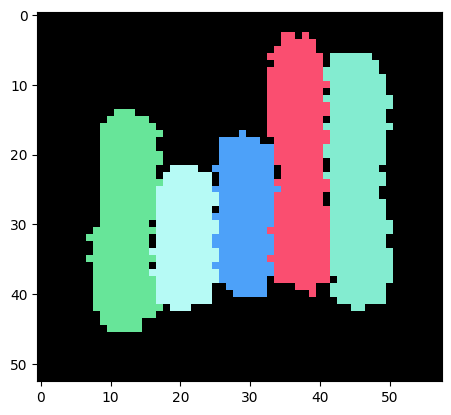

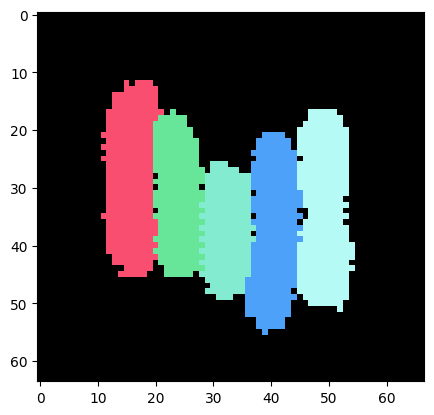

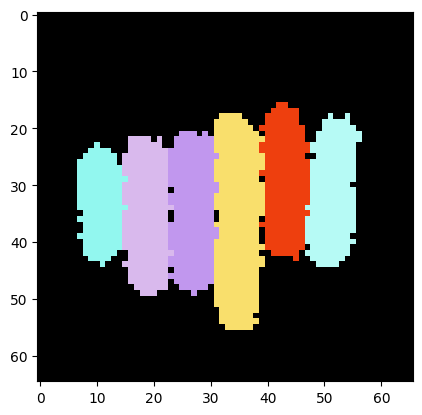

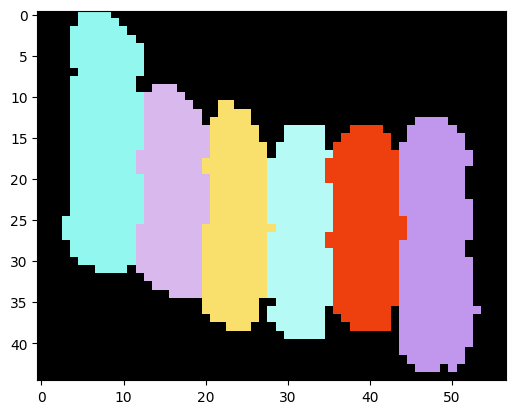

[8.8, 8.4, 8.166666666666666, 8.8, 8.6, 8.166666666666666, 8.333333333333334]

In [90]:
get_patch_widths(masks_stack_symbac, lines, True)

In [30]:
all_stacks = get_patch_widths(masks_stack_symbac, lines, return_stacks=True)

In [35]:
from matplotlib_scalebar.scalebar import ScaleBar


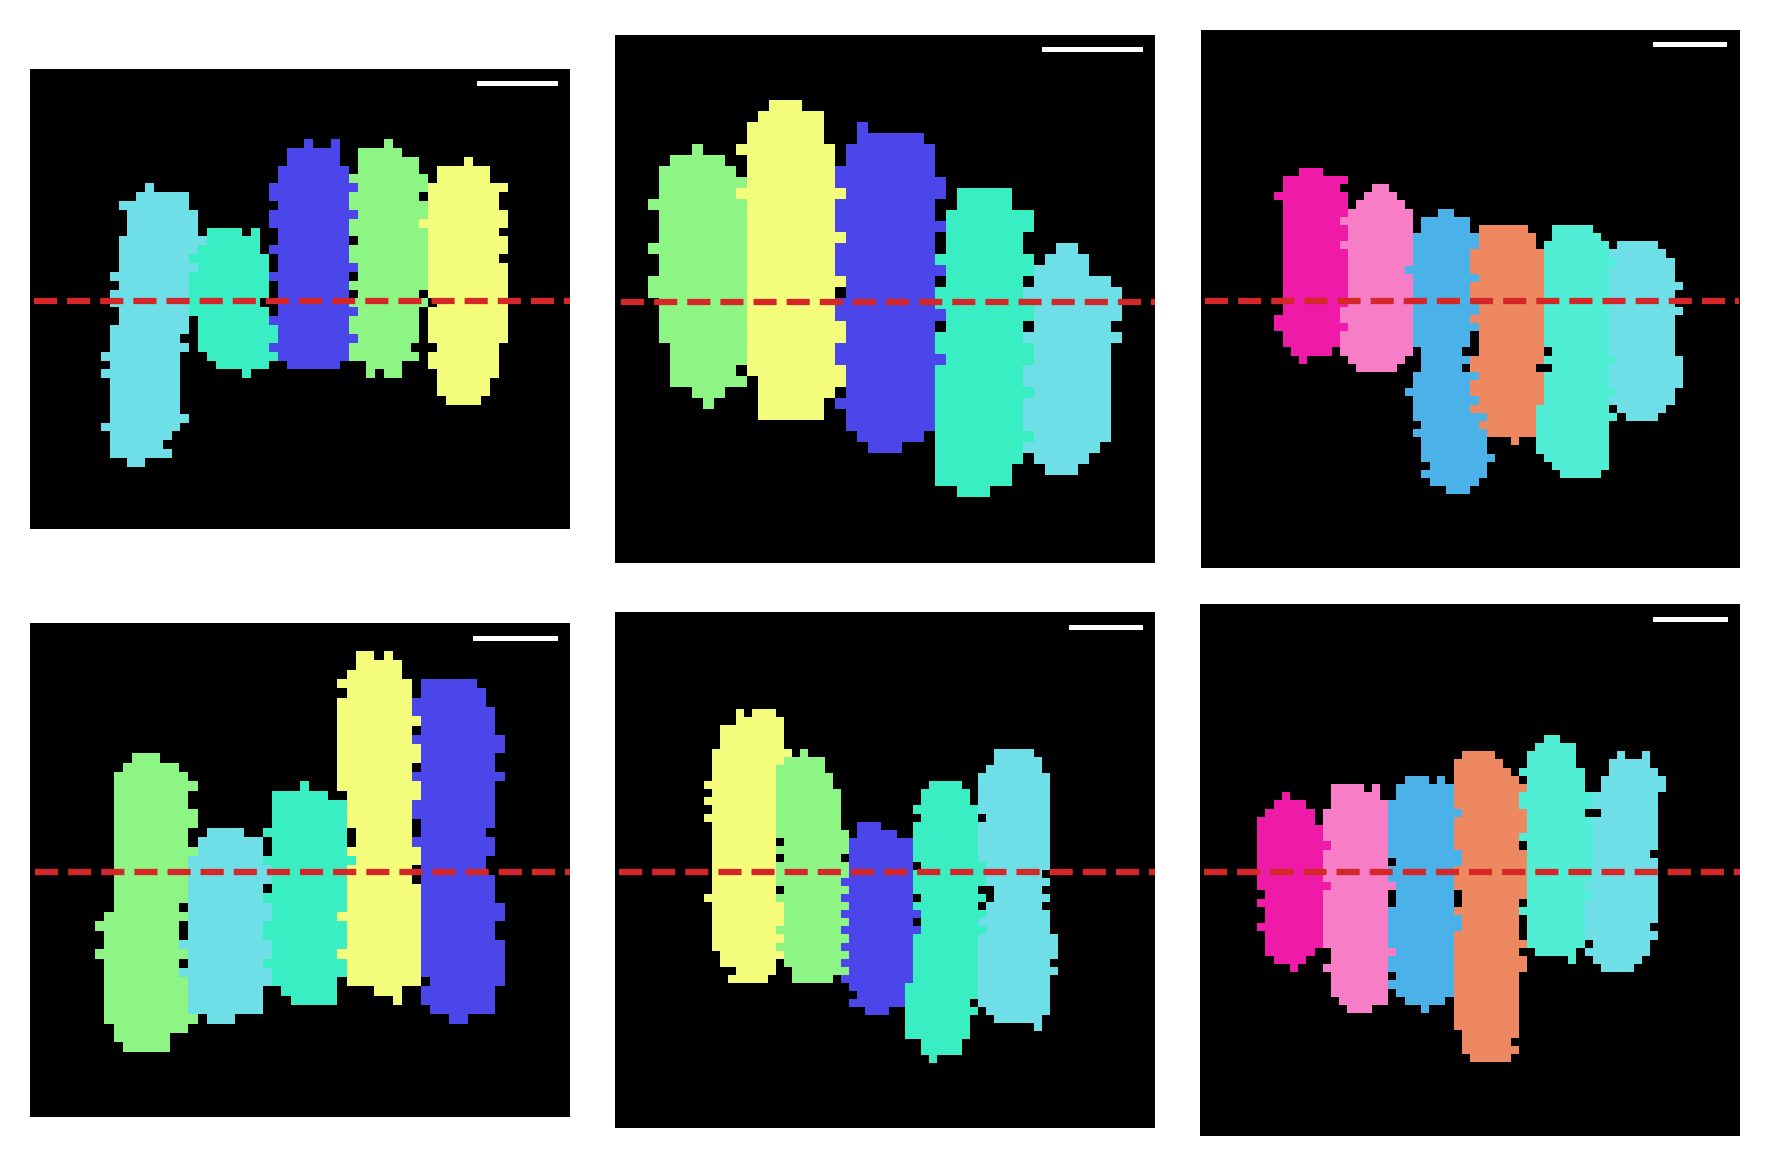

In [60]:
fig, axs = plt.subplots(2,3, figsize = (6,4), dpi = 300)
for i, ax in enumerate(axs.flatten()):
    
    ax.imshow(all_stacks[i], label_cmap, interpolation = "none")
    ax.set_axis_off()
    ax.plot([0,ax.get_xlim()[1]], [ax.get_ylim()[0]/2, ax.get_ylim()[0]/2], c = "tab:red", linestyle = "--")
    scalebar = ScaleBar(0.11, "um", length_fraction=0.25, scale_loc="none", box_alpha=0, color="white", box_color="k") # 1 micon
    ax.add_artist(scalebar)

plt.tight_layout()
plt.savefig("SI_PATCHES.png")